# Assess the time comlexity of Theorem 2 vs Theorem 1

In [1]:
from functools import reduce
import itertools
from math import factorial
import time
import networkx as nx
import numpy as np
from utils.utils import PartitionManager
from discreteMarkovChain import markovChain
from pprint import pprint

def get_ordered_combinations(state_vector, m):
    return list(itertools.permutations(state_vector, m))

def generate_contact_network(walker_partition):
    """
    walker_partition = Partition on all walkers
    """
    G = nx.Graph()
    cliques = [nx.complete_graph(clique) for clique in walker_partition]
    for clique in cliques:
        G = nx.compose(G, clique)
    return G

def sigma(clique, S_k):
    return np.sum(np.prod(S_k[:, clique], axis=1))


def _generate_sigma_dict(contact_networks, S_k, verbose=False):
    """
    Generate sigma probabilities (independent probabilities of cliques of walkers)
    """
    
    sigma_dict = {}
    for contact_network in contact_networks.values():
        walker_partition = contact_network['partition']
        if verbose:
            print(f'Walker partition: {walker_partition}')
        for clique in walker_partition:
            if tuple(sorted(clique)) not in sigma_dict.keys():
                if not isinstance(clique[0], int):
                    clique = list(reduce(np.union1d, clique))
                sigma_dict[tuple(sorted(clique))] = sigma(clique, S_k)
                if verbose:
                    print(f'Sigma for clique {clique}: {sigma_dict[tuple(sorted(clique))]}')
    return sigma_dict

def generate_contact_network_probability_theorem1(cliques, sigma_product_dict):
    """
    (Theorem 2): RWIG Logic for computing the probability of a contact network 
    """
    
    amassed_clique_graphs = PartitionManager(cliques).return_partition(with_union=False)
    # t0 = time.time()
    G_k_proba = 0.
    for g_pi in amassed_clique_graphs:
        sigma_product = 1.
        num_automorphisms = np.prod([factorial(len(clique)-1) for clique in g_pi])
        sign = np.prod([(-1)**(len(clique)-1) for clique in g_pi])
        for clique in g_pi:
            sigma_product *= sigma_product_dict[tuple(reduce(np.union1d, clique))]
        G_k_proba += sign * sigma_product * num_automorphisms

    # t1 = time.time()
    return G_k_proba,

def generate_contact_network_probability_combinatorial(cliques, S_k, state_vector, verbose=False):
    proba = 0.
    # t0 = time.time()
    all_different_clique_states = get_ordered_combinations(state_vector, len(cliques))
    if verbose:
        print(f'all_different_clique_states {all_different_clique_states}')
        print(f'Length of all_different_clique_states {len(all_different_clique_states)}')
    for clique_states in all_different_clique_states:
        walker_states_probas = [np.prod(S_k[clique_state_index, walkers_in_clique]) 
                                for clique_state_index, walkers_in_clique in zip(clique_states, cliques)]
        joint_clique_proba = np.prod(walker_states_probas)

        if verbose:
            print(f'different_clique_states: {clique_states}')
            print(f'walker states probas {walker_states_probas}')
            print(f'joint_clique_proba {joint_clique_proba}')
            print(f'----------')
        proba += joint_clique_proba
    # t1 = time.time()
    return proba

def generate_contact_network_distribution(contact_networks, S_k, use_theorem1=False, verbose=False, repetitions=1):
    """
    Generate the probability of a contact network realisation
    """
    if verbose:
        print(f'Number of possible contact graphs: {len(contact_networks)}')
        print(f'Generating sigma probabilities')
    if use_theorem1:
        t0 = time.time()
        for _ in range(repetitions):
            sigma_dict = _generate_sigma_dict(contact_networks, S_k, verbose=verbose)
        t1 = time.time()
        dt_total = (t1 - t0) / repetitions
    else:
        t0 = time.time()
        state_vector = np.arange(0, S_k.shape[0])
        t1 = time.time()
        dt_total = t1 - t0
    # i = 0
    t0 = time.time()
    for _ in range(repetitions):
        for key, contact_network in contact_networks.items():
            cliques = contact_network['partition']
            if use_theorem1:
                contact_networks[key]['proba'] = generate_contact_network_probability_theorem1(cliques, sigma_dict)
            else:
                contact_networks[key]['proba'] = generate_contact_network_probability_combinatorial(cliques, S_k, state_vector)

    t1 = time.time()
    dt_total += (t1 - t0) / repetitions
        # i += 1
        # if i == 2:
        #     break
    return contact_networks, dt_total


  0%|          | 0/5 [00:00<?, ?it/s]

------------M=3, N=3------------
Time took using theorem 1: 0.00021617865562438963
Time took using combinatorial: 0.0002899680137634277
Time gain: 1.3413350773503148
-----------------------------------


------------M=3, N=4------------
Time took using theorem 1: 0.00022609100341796875
Time took using combinatorial: 0.0006906577587127685
Time gain: 3.054777714600023
-----------------------------------


------------M=3, N=5------------
Time took using theorem 1: 0.0002209177017211914
Time took using combinatorial: 0.00159575252532959
Time gain: 7.22328954582148
-----------------------------------


------------M=3, N=6------------
Time took using theorem 1: 0.00021991090774536133
Time took using combinatorial: 0.0031367923736572265
Time gain: 14.263923539842658
-----------------------------------


 20%|██        | 1/5 [00:59<03:59, 59.96s/it]

------------M=3, N=7------------
Time took using theorem 1: 0.0002868143081665039
Time took using combinatorial: 0.005096320867538452
Time gain: 17.76871209849089
-----------------------------------


------------M=4, N=3------------
Time took using theorem 1: 0.0009467255592346192
Time took using combinatorial: 0.001233387517929077
Time gain: 1.3027930913011474
-----------------------------------


------------M=4, N=4------------
Time took using theorem 1: 0.0015032012939453126
Time took using combinatorial: 0.0041367975234985355
Time gain: 2.751991726032292
-----------------------------------


------------M=4, N=5------------
Time took using theorem 1: 0.0015466593265533446
Time took using combinatorial: 0.010586759853363038
Time gain: 6.844920320595175
-----------------------------------


------------M=4, N=6------------
Time took using theorem 1: 0.0013332376480102539
Time took using combinatorial: 0.021943503904342652
Time gain: 16.458809078105094
-----------------------------------


 40%|████      | 2/5 [08:25<14:20, 286.97s/it]

------------M=4, N=7------------
Time took using theorem 1: 0.0015166447639465331
Time took using combinatorial: 0.044426809883117674
Time gain: 29.292825148792634
-----------------------------------


------------M=5, N=3------------
Time took using theorem 1: 0.0035999940395355224
Time took using combinatorial: 0.0034806640625
Time gain: 0.9668527292753745
-----------------------------------


------------M=5, N=4------------
Time took using theorem 1: 0.00773522777557373
Time took using combinatorial: 0.01805670394897461
Time gain: 2.3343467668778928
-----------------------------------


------------M=5, N=5------------
Time took using theorem 1: 0.009400631427764893
Time took using combinatorial: 0.05633736276626587
Time gain: 5.992933900149803
-----------------------------------


------------M=5, N=6------------
Time took using theorem 1: 0.010110042095184327
Time took using combinatorial: 0.16301064825057984
Time gain: 16.123636945906092
-----------------------------------


 60%|██████    | 3/5 [16:02<12:09, 364.55s/it]

------------M=5, N=7------------
Time took using theorem 1: 0.011033037185668946
Time took using combinatorial: 0.335001895904541
Time gain: 30.363524591368396
-----------------------------------


------------M=6, N=3------------
Time took using theorem 1: 0.01315061960220337
Time took using combinatorial: 0.0133921950340271
Time gain: 1.0183698897185995
-----------------------------------


------------M=6, N=4------------
Time took using theorem 1: 0.039862839841842655
Time took using combinatorial: 0.07596906204223633
Time gain: 1.9057614144814192
-----------------------------------


------------M=6, N=5------------
Time took using theorem 1: 0.0687043194770813
Time took using combinatorial: 0.3155805912017822
Time gain: 4.593315145302546
-----------------------------------


------------M=6, N=6------------
Time took using theorem 1: 0.07686947441101073
Time took using combinatorial: 1.030876531600952
Time gain: 13.410739952363848
-----------------------------------


 80%|████████  | 4/5 [1:02:26<21:59, 1319.55s/it]

------------M=6, N=7------------
Time took using theorem 1: 0.07506048631668091
Time took using combinatorial: 2.5759030537605287
Time gain: 34.31769736866304
-----------------------------------


------------M=7, N=3------------
Time took using theorem 1: 0.036383433008193966
Time took using combinatorial: 0.03347427129745483
Time gain: 0.9200415829346297
-----------------------------------


------------M=7, N=4------------
Time took using theorem 1: 0.19693624320030212
Time took using combinatorial: 0.3543056240081787
Time gain: 1.799087959892774
-----------------------------------


------------M=7, N=5------------
Time took using theorem 1: 0.4295324382781982
Time took using combinatorial: 1.5102138552665711
Time gain: 3.5159483212032536
-----------------------------------


------------M=7, N=6------------
Time took using theorem 1: 0.6353115320205689
Time took using combinatorial: 5.5206505994796755
Time gain: 8.6896747835217
-----------------------------------


100%|██████████| 5/5 [5:38:26<00:00, 4061.40s/it]

------------M=7, N=7------------
Time took using theorem 1: 0.522212140083313
Time took using combinatorial: 18.291536707401274
Time gain: 35.0270231260481
-----------------------------------


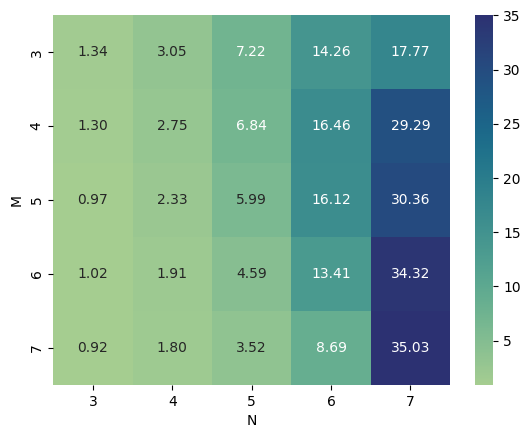

In [2]:

from tqdm import tqdm


M_list = [3, 4, 5, 6, 7]
N_list = [3, 4, 5, 6, 7]

theorem1_dts = {}
combinatorial_dts = {}
time_gain = np.zeros((len(M_list), len(N_list)))
for M in tqdm(M_list):
    for N in tqdm(N_list):
        if M < 5 or N < 5:
            repetitions = 5000
        else:
            repetitions = 500
        walker_indices = list(range(M))
        contact_network_sample_space = PartitionManager(walker_indices).return_partition()
        contact_network_sample_space = [walker_partition for walker_partition in contact_network_sample_space if len(walker_partition) <= N]
        contact_networks = {str(walker_partition):
                                    {'network': generate_contact_network(walker_partition),
                                    'partition': walker_partition,
                                    } for _, walker_partition in enumerate(contact_network_sample_space)}

        arr = [1/N] * (N-1)
        P = np.array(arr + [1-np.sum(arr)]).repeat(N).reshape(N, N).transpose()


        mc = markovChain(P.transpose())  # Transpose P to get column-stochastic
        mc.computePi('linear')  # Compute stationary distribution

        walkers_initial_states = mc.pi.repeat(M).reshape(M, N).transpose()


        contact_networks, dt_theorem1 = generate_contact_network_distribution(contact_networks, walkers_initial_states, use_theorem1=True, verbose=False, repetitions=repetitions)

        contact_networks, dt_combinatorial = generate_contact_network_distribution(contact_networks, walkers_initial_states, use_theorem1=False, verbose=False, repetitions=repetitions)

        theorem1_dts[(M, N)] = dt_theorem1
        combinatorial_dts[(M, N)] = dt_combinatorial
        time_gain[M_list.index(M), N_list.index(N)] = dt_combinatorial / dt_theorem1

        print(f'------------M={M}, N={N}------------')
        print(f'Time took using theorem 1: {dt_theorem1}')
        print(f'Time took using combinatorial: {dt_combinatorial}')
        print(f'Time gain: {dt_combinatorial / dt_theorem1}')
        print('-----------------------------------')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ax = sns.heatmap(time_gain, fmt=".2f",
                  cmap='crest',
                #   cmap=sns.diverging_palette(220, 20, as_cmap=True),
                  annot=True,
                    xticklabels=N_list, yticklabels=M_list)
plt.xlabel('N')
plt.ylabel('M')
plt.show()

